In [218]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from functions import *

In [219]:
def k_distance_plot(data, k):
    """
    Creates a k-distance graph to help determine the optimal eps value for DBSCAN.

    Args:
        data (pd.DataFrame or np.array): The dataset.
        k (int): The value of min_samples (number of nearest neighbors).

    Returns:
        None (displays the plot).
    """

    # Calculate distances to the k-th nearest neighbor
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(data)
    distances, indices = neighbors.kneighbors(data)
    distances = np.sort(distances[:, k-1]) # take the kth distance for each point, and sort the distances

    # Plot the k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
    plt.title(f"K-Distance Graph (k={k})")
    plt.grid(True)
    plt.show()

In [220]:
X = pd.read_csv("indep_x.csv", index_col = 0)
y = pd.read_csv("dep_y.csv", index_col = 0)

In [221]:
df = pd.concat([X,y], axis = 1)
df = df[df["gpa"] != 31]

In [222]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [223]:
min_samples = 5

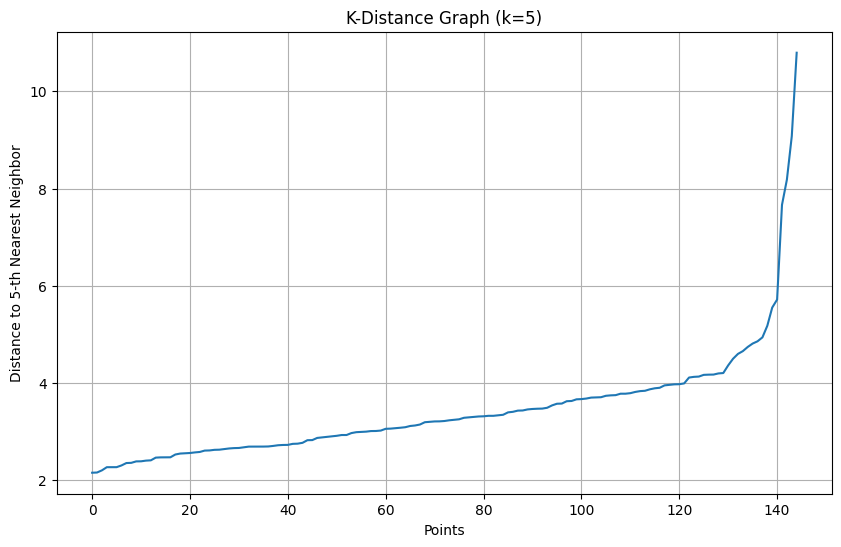

In [224]:
k_distance_plot(scaled_data, min_samples)

In [225]:
dbscan = DBSCAN(eps=4, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_data)

In [226]:
outlier_indices = clusters == -1
df_no_outliers = df[~outlier_indices]

df_no_outliers.shape

(132, 16)

In [227]:
df2 = df_no_outliers.copy()

In [208]:
scaled_data2 = scaler.fit_transform(df2)

In [228]:
n_clusters = 3

In [229]:
spectral_clustering = SpectralClustering(
    n_clusters=n_clusters,
    assign_labels='discretize', 
    random_state=42
)

In [230]:
clusters = spectral_clustering.fit_predict(scaled_data2)

In [231]:
df2["cluster"] = clusters

In [232]:
cluster_profiles = df2.groupby("cluster").mean()
print(cluster_profiles)

               age    gender  scholarship  1st_year        gpa  1st_time  \
cluster                                                                    
0        19.722689  0.478992          0.0       1.0  24.638655       1.0   
1        19.000000  1.000000          0.0       1.0  26.000000       1.0   
2        19.454545  0.636364          1.0       1.0  26.818182       1.0   

            taste  importance  expected_grade  knowledge   treated  \
cluster                                                              
0        3.352941    3.991597       21.529412   0.302521  0.521008   
1        4.000000    4.000000       29.000000   1.000000  1.000000   
2        3.454545    3.727273       22.636364   0.363636  0.636364   

         grade_goal  confidence   anxiety      time  exam_date  
cluster                                                         
0         24.941176    3.453782  3.310924  4.605042   1.117647  
1         30.500000    5.000000  5.000000  4.000000   1.000000  
2       

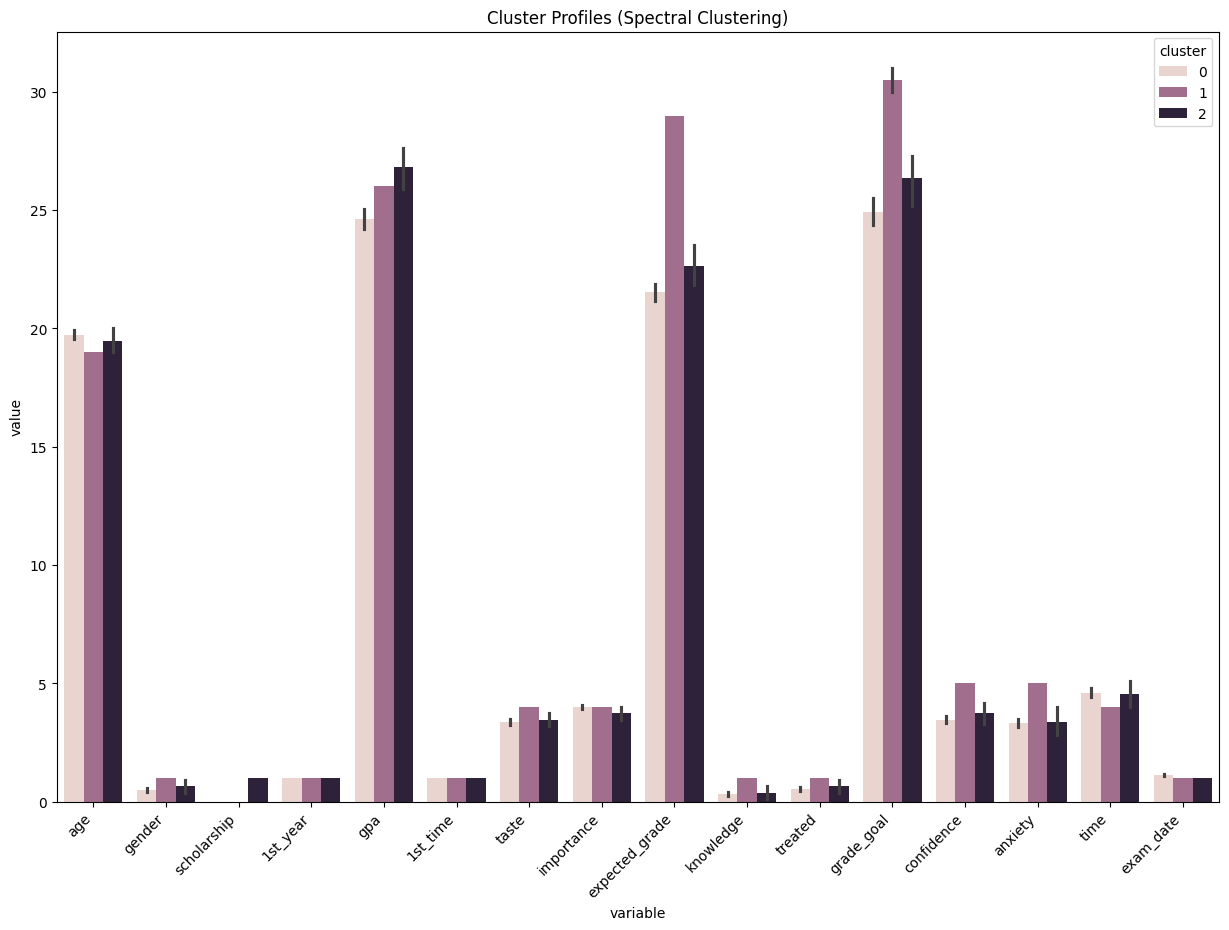

In [214]:
plt.figure(figsize=(15, 10))
sns.barplot(data=df2.melt(id_vars='cluster'), x='variable', y='value', hue='cluster')
plt.xticks(rotation=45, ha='right') 
plt.title("Cluster Profiles (Spectral Clustering)")
plt.show()

In [215]:
def calculate_significance(df, feature, cluster_col="cluster"):
    """
    Calculates statistical significance for a feature across clusters.

    Args:
        df (pd.DataFrame): The DataFrame containing your data.
        feature (str): The name of the feature column.
        cluster_col (str): The name of the cluster column.

    Returns:
        dict: A dictionary containing the p-values for pairwise comparisons.
    """

    clusters = df[cluster_col].unique()
    p_values = {}

    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            cluster_i_data = df[df[cluster_col] == clusters[i]][feature]
            cluster_j_data = df[df[cluster_col] == clusters[j]][feature]

            # Choose appropriate test based on data type and distribution
            if pd.api.types.is_numeric_dtype(df[feature]):
                # Example: Independent t-test for numerical data (if normally distributed)
                t_stat, p_val = stats.ttest_ind(cluster_i_data, cluster_j_data, nan_policy='omit') #omit nan values
                p_values[f"{feature}: Cluster {clusters[i]} vs {clusters[j]}"] = p_val

            else:
                # Example: Chi-squared test for categorical data
                contingency_table = pd.crosstab(df[df[cluster_col].isin([clusters[i], clusters[j]])][cluster_col], df[df[cluster_col].isin([clusters[i], clusters[j]])][feature])
                chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
                p_values[f"{feature}: Cluster {clusters[i]} vs {clusters[j]}"] = p_val

    return p_values

In [216]:
significance_results = {}
for feature in df2.columns:
    significance_results[feature] = calculate_significance(df, feature)

KeyError: 'cluster'

In [ ]:
# Print the results
for feature, p_values in significance_results.items():
    print(f"Significance for {feature}:")
    for comparison, p_value in p_values.items():
        print(f"  {comparison}: p = {p_value}")